In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt

import glob   
from skimage.io import imread, imshow
from skimage.transform import resize

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.model_selection import train_test_split

from PIL import Image
import albumentations as A
import cv2

import os
import time
from tqdm.notebook import tqdm

!pip install segmentation-models-pytorch
!pip install torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     |████████████████████████████████| 88 kB 5.8 MB/s 
     |████████████████████████████████| 376 kB 54.9 MB/s 
     |████████████████████████████████| 58 kB 6.3 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=4ff781270daf10f130c82a5d2c8cf038df16be12deefeee956344f589c506543
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=74d5a09624cc1b068dde13c06f73f83ce0e8e90252c40842d1b610b32def0d1e
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
# Input data files are available in the read-only "../input/" directory
train_images = '/content/drive/MyDrive/DL/train_images'
train_masks = '/content/drive/MyDrive/DL/train_masks'
test_image = '/content/drive/MyDrive/DL/test_images'

# **DATA Vizualization**

In [4]:
# Get the directories of all images and masks
train_x = sorted(glob.glob(train_images + '/*.jpg'))
train_y = sorted(glob.glob(train_masks+'/*.png'))
test_x = glob.glob(test_image+'/*.jpg')


print('Train Images:', len(train_x))
print('Test Images:', len(test_x))

Train Images: 261
Test Images: 112


Image Size: (3000, 4000)
Mask Size: (3000, 4000)


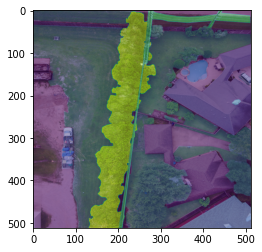

In [5]:
# Randomly select and image/mask pair from the training set
idx = np.random.choice(range(len(train_x)))
#idx = np.random.choice(range(38))

#img = Image.open(train_images+'6411.jpg')
#msk = Image.open(train_masks+'6411.png')
img = Image.open(train_x[idx])
msk = Image.open(train_y[idx])

print('Image Size:',img.size)
print('Mask Size:',msk.size)

# # Show the image
plt.imshow(img.resize((512,512)))
plt.imshow(msk.resize((512,512)), alpha=0.5)
plt.show()

# Taking a look at the images

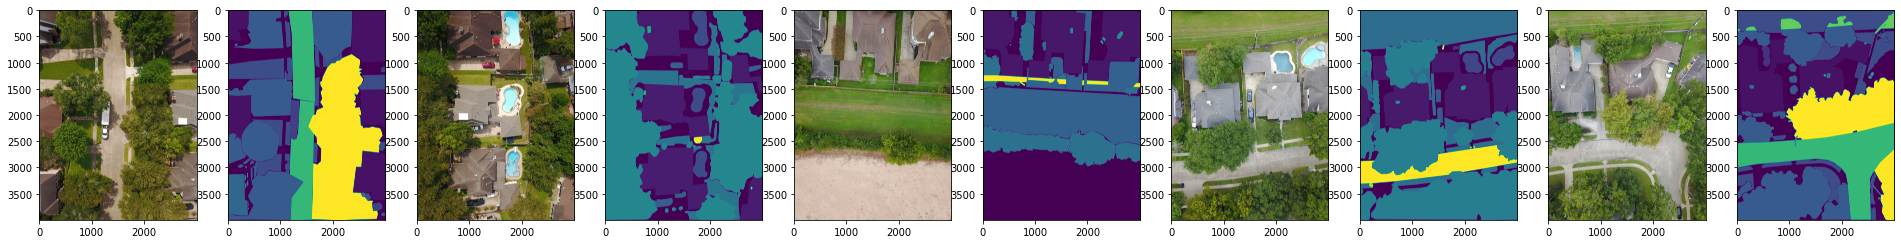

In [6]:
ids= ['10172','10174','10300','10810','10814']
plt.figure(figsize=(40,30))
for j, img_name in enumerate(ids):
    q = j+1
    img = imread(train_images + "/" + img_name + '.jpg')
    img_mask = imread(train_masks + "/" + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

# Preprocessing


In [9]:
def create_df():
    name = []
    for dirname, _, filenames in os.walk(train_images):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  261


In [10]:
#split into training and validation = 15%

X_train, X_val = train_test_split(df['id'].values, test_size=0.1, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))


Train Size   :  234
Val Size     :  27


In [24]:
type(X_train)

numpy.ndarray

Image Size (4592, 3072, 3)
Mask Size (4592, 3072)


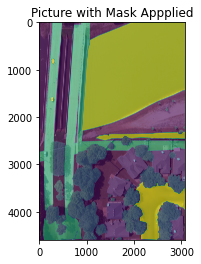

In [11]:
img = imread(train_images + "/" + df['id'][50] + '.jpg')
mask = imread(train_masks + "/" + df['id'][50] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

# Dataloader


In [12]:
class SegmentationDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        
        
        img = cv2.imread(self.img_path + "/" + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + "/" + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [13]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = SegmentationDataset(img_path = train_images, mask_path = train_masks, X = X_train, mean = mean, std = std, transform = t_train, patch=False)
val_set = SegmentationDataset(img_path = train_images, mask_path = train_masks, X = X_val, mean = mean, std = std, transform = t_val, patch=False)

#dataloader
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [14]:
len(train_set)

234

# Modelling (UNET)


In [15]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=25, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [16]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), 

# Training


In [17]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [18]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=25):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [19]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [20]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))
history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.525 
Epoch:1/15.. Train Loss: 3.101.. Val Loss: 2.525.. Train mIoU:0.039.. Val mIoU: 0.079.. Train Acc:0.152.. Val Acc:0.364.. Time: 4.71m


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 2.525 >> 1.690 
Epoch:2/15.. Train Loss: 2.124.. Val Loss: 1.690.. Train mIoU:0.124.. Val mIoU: 0.145.. Train Acc:0.481.. Val Acc:0.579.. Time: 3.38m


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 1.690 >> 1.293 
Epoch:3/15.. Train Loss: 1.499.. Val Loss: 1.293.. Train mIoU:0.159.. Val mIoU: 0.161.. Train Acc:0.579.. Val Acc:0.611.. Time: 3.39m


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 1.293 >> 1.160 
saving model...
Epoch:4/15.. Train Loss: 1.350.. Val Loss: 1.160.. Train mIoU:0.167.. Val mIoU: 0.171.. Train Acc:0.584.. Val Acc:0.637.. Time: 3.38m


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 1.160 >> 1.017 
Epoch:5/15.. Train Loss: 1.240.. Val Loss: 1.017.. Train mIoU:0.181.. Val mIoU: 0.218.. Train Acc:0.610.. Val Acc:0.688.. Time: 3.38m


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:6/15.. Train Loss: 1.158.. Val Loss: 1.037.. Train mIoU:0.197.. Val mIoU: 0.209.. Train Acc:0.623.. Val Acc:0.675.. Time: 3.40m


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 1.037 >> 0.997 
Epoch:7/15.. Train Loss: 1.119.. Val Loss: 0.997.. Train mIoU:0.206.. Val mIoU: 0.216.. Train Acc:0.635.. Val Acc:0.692.. Time: 3.40m


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:8/15.. Train Loss: 1.039.. Val Loss: 1.019.. Train mIoU:0.224.. Val mIoU: 0.223.. Train Acc:0.666.. Val Acc:0.691.. Time: 3.41m


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 1.019 >> 0.989 
Epoch:9/15.. Train Loss: 1.010.. Val Loss: 0.989.. Train mIoU:0.229.. Val mIoU: 0.236.. Train Acc:0.670.. Val Acc:0.706.. Time: 3.40m


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.989 >> 0.921 
Epoch:10/15.. Train Loss: 0.993.. Val Loss: 0.921.. Train mIoU:0.232.. Val mIoU: 0.228.. Train Acc:0.685.. Val Acc:0.709.. Time: 3.38m


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.921 >> 0.878 
saving model...
Epoch:11/15.. Train Loss: 0.947.. Val Loss: 0.878.. Train mIoU:0.249.. Val mIoU: 0.237.. Train Acc:0.699.. Val Acc:0.726.. Time: 3.39m


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.878 >> 0.866 
Epoch:12/15.. Train Loss: 0.895.. Val Loss: 0.866.. Train mIoU:0.259.. Val mIoU: 0.256.. Train Acc:0.722.. Val Acc:0.730.. Time: 3.38m


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.866 >> 0.851 
Epoch:13/15.. Train Loss: 0.852.. Val Loss: 0.851.. Train mIoU:0.268.. Val mIoU: 0.276.. Train Acc:0.732.. Val Acc:0.749.. Time: 3.41m


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.851 >> 0.834 
Epoch:14/15.. Train Loss: 0.839.. Val Loss: 0.834.. Train mIoU:0.273.. Val mIoU: 0.293.. Train Acc:0.738.. Val Acc:0.750.. Time: 3.37m


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:15/15.. Train Loss: 0.833.. Val Loss: 0.836.. Train mIoU:0.271.. Val mIoU: 0.280.. Train Acc:0.742.. Val Acc:0.750.. Time: 3.35m
Total time: 52.11 m


In [22]:
torch.save(model, '/content/drive/MyDrive/DL/Unet-Mobilenet.pt')

In [23]:
column = list(history.keys())[:-1]
val = list(history.values())[:-1]
test = dict(zip(column, val))
df = pd.DataFrame.from_dict(test, orient='index')
nn_crs = df.transpose()
nn_crs.to_csv('Unet-Mobilenet_v2_cross_entropy.csv')

In [24]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

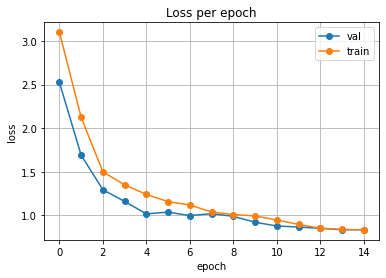

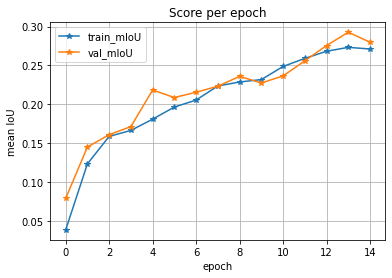

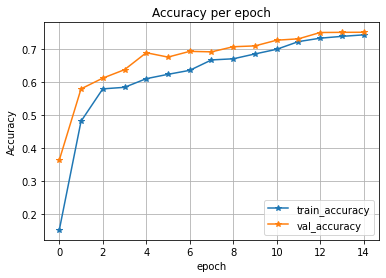

In [25]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [85]:
model = torch.load('/content/drive/MyDrive/DL/Unet-Mobilenet.pt')
model.eval()

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), 

In [86]:
def create_df():
    name = []
    for dirname, _, filenames in os.walk(test_image):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  112


In [87]:
X_test = df['id'].to_numpy()

In [88]:
class SegmentationDatasetTest(Dataset):
    
    def __init__(self, img_path, X, transform=None):
        self.img_path = img_path
        self.X = X
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        
        
        img = cv2.imread(self.img_path + "/" + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # mask = cv2.imread(self.mask_path + "/" + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img)
            img = Image.fromarray(aug['image'])
        
        if self.transform is None:
            img = Image.fromarray(img)
            
        return img

t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = SegmentationDatasetTest(test_image, X_test, transform=t_test)

In [89]:
def prepare_plot(origImage, predMask):

  figure, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 10))

  ax[0] = imshow(origImag)
  ax[1] = imshow(predMask)

  ax[0].set_title('Image')
  ax[1].set_title('Predicted Mask')

  figure.tight_layout()
  figure.show()

In [90]:
def make_prediction_mask(model, image, mean, std):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        
        output = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

In [105]:
image = test_set[30]
pred_mask = make_prediction_mask(model, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [82]:
# for i in tqdm(range(len(test_set))):

#   img = test_set[i]
#   pred_mask = make_prediction_mask(model, img, mean = mean, std = std)


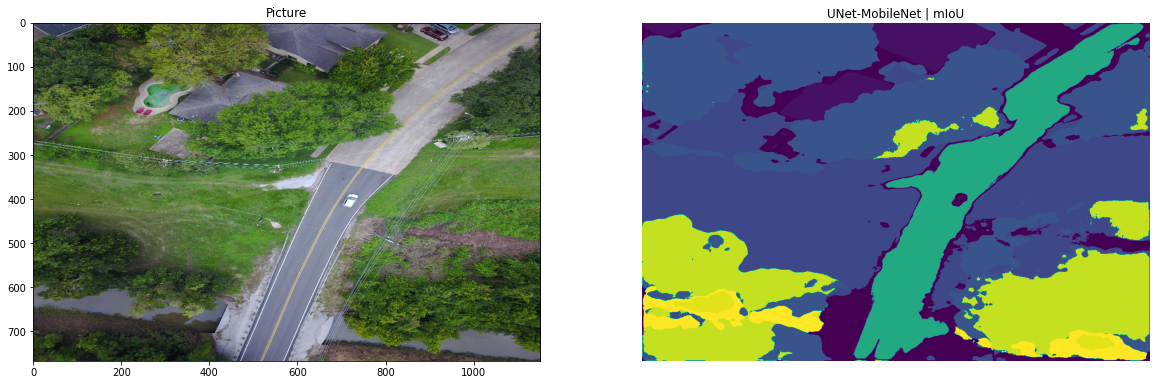

In [106]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(pred_mask)
ax2.set_title('UNet-MobileNet | mIoU')
ax2.set_axis_off()